The cross comparison method is proposed by Woz: https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithmic_contest:_SuperMemo_2_vs._SuperMemo_17

In [1]:
import pandas as pd
from pathlib import Path

dfs = []

for file in Path("./raw").glob("*.csv"):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
df.rename(columns={"R (SM17)": "R (SM-17)"}, inplace=True)
df.rename(columns={"R (SM16)": "R (SM-16)"}, inplace=True)
df.head()

,y,R (SM-16),R (SM-17),R (AVG),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
0,1,0.841,0.866,0.641176,0.720,0.545,0.640,0.603,0.660
1,1,0.684,0.548,0.557143,0.464,0.340,0.478,0.444,0.582
2,1,0.698,0.667,0.900000,0.464,0.340,0.478,0.444,0.582
3,1,0.810,0.981,0.593333,0.730,0.503,0.654,0.622,0.740
4,1,0.796,0.916,0.595000,0.645,0.474,0.585,0.548,0.633


In [2]:
df.describe()

,y,R (SM-16),R (SM-17),R (AVG),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
count,194283.000000,194283.000000,194283.000000,194283.000000,194283.000000,194283.000000,194283.00000,194283.000000,194283.000000
mean,0.866900,0.853809,0.878369,0.839692,0.836515,0.827929,0.83994,0.837738,0.850367
std,0.339683,0.157810,0.152640,0.075660,0.179847,0.176586,0.15264,0.154502,0.108861
min,0.000000,0.000000,0.000000,0.064286,0.000000,0.004000,0.03100,0.031000,0.207000
25%,1.000000,0.822000,0.812000,0.805327,0.802000,0.773000,0.78200,0.780000,0.795000
50%,1.000000,0.912000,0.932000,0.866774,0.897000,0.890000,0.89100,0.889000,0.875000
75%,1.000000,0.950000,0.995000,0.893810,0.949000,0.950000,0.94900,0.947000,0.932000
max,1.000000,0.999000,1.000000,0.996970,1.000000,1.000000,1.00000,1.000000,1.000000


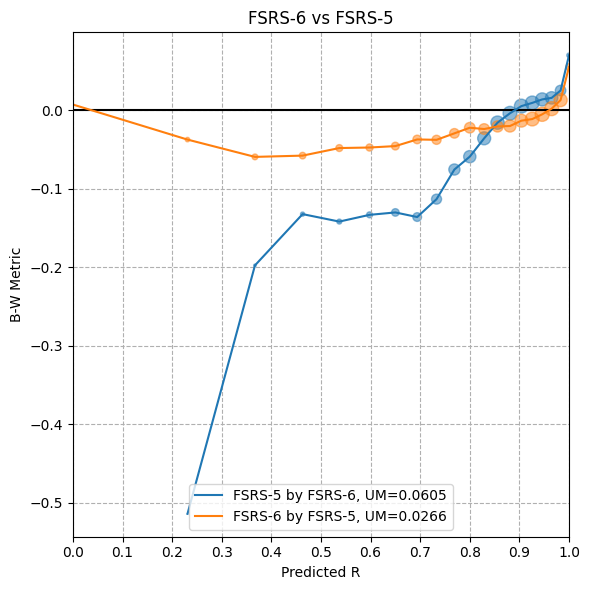

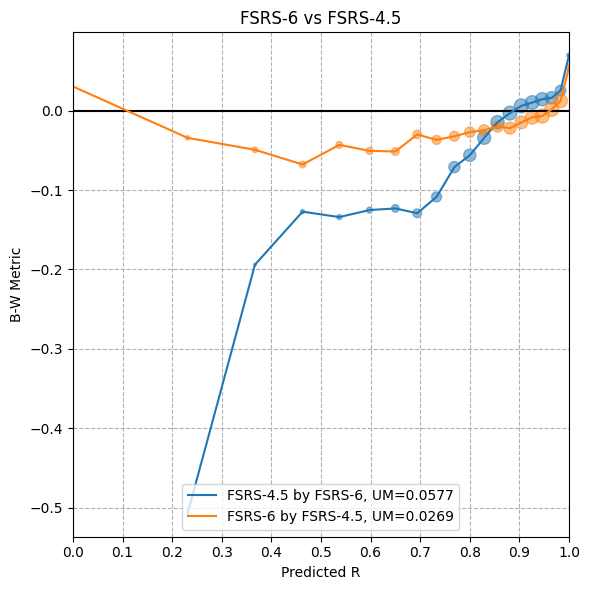

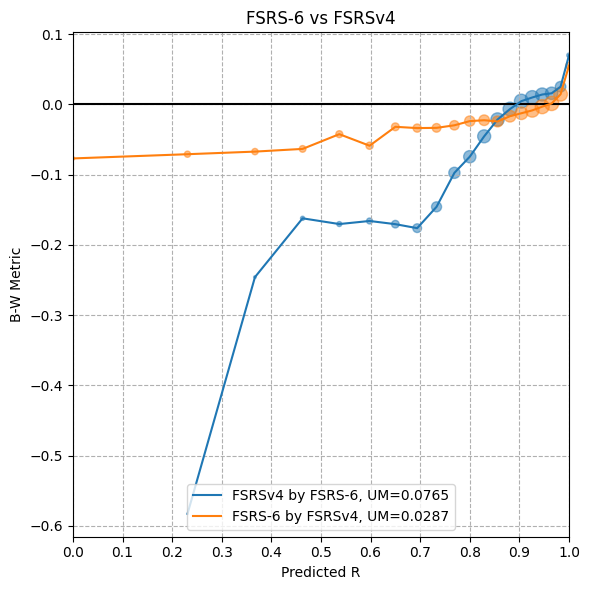

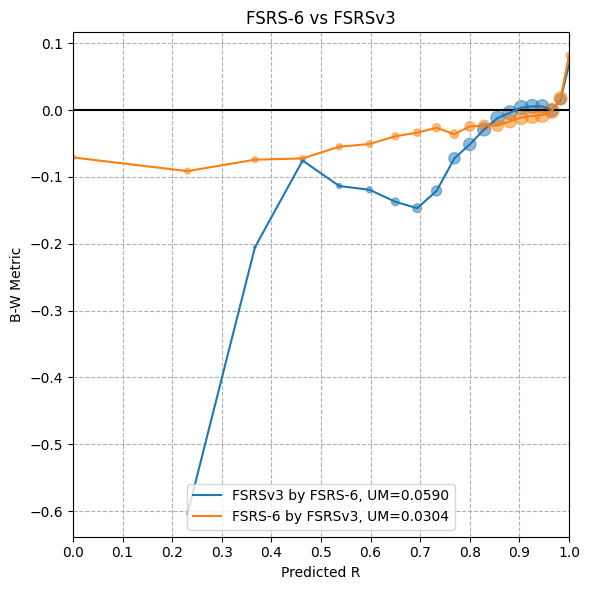

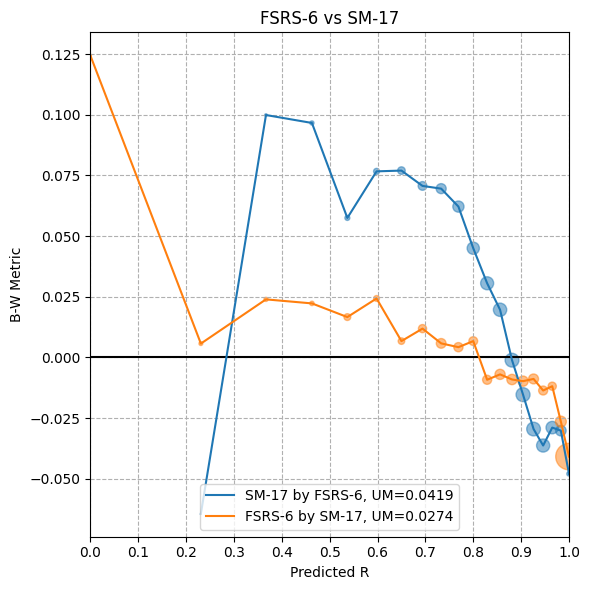

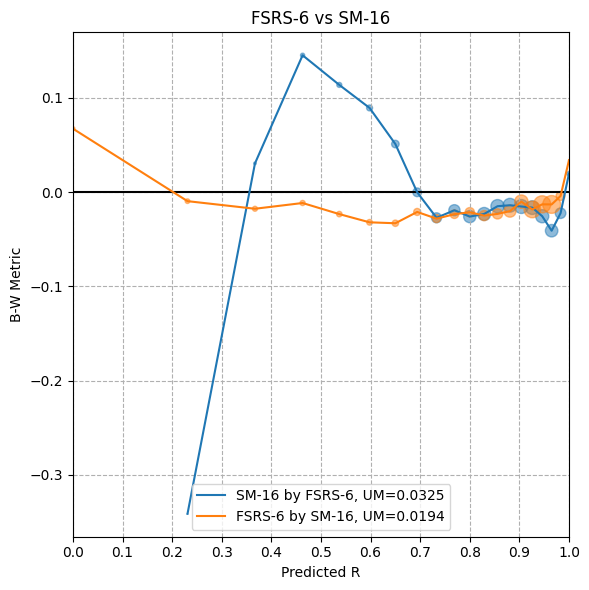

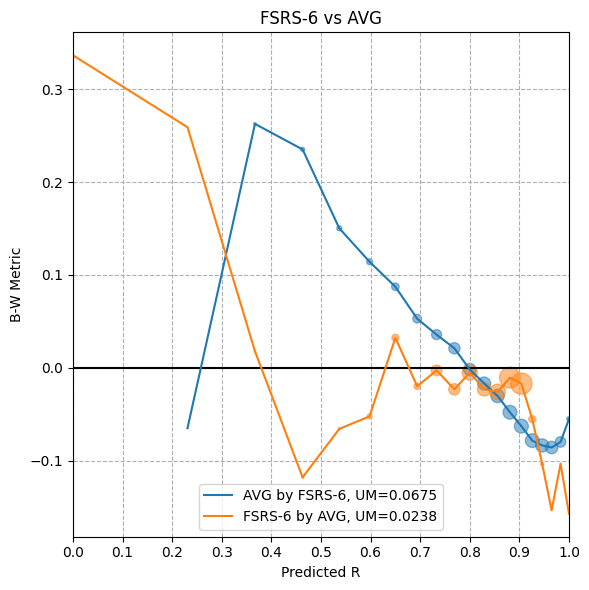

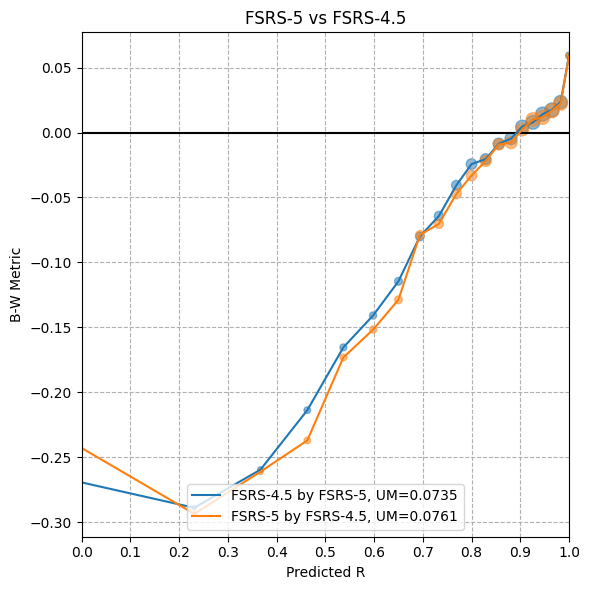

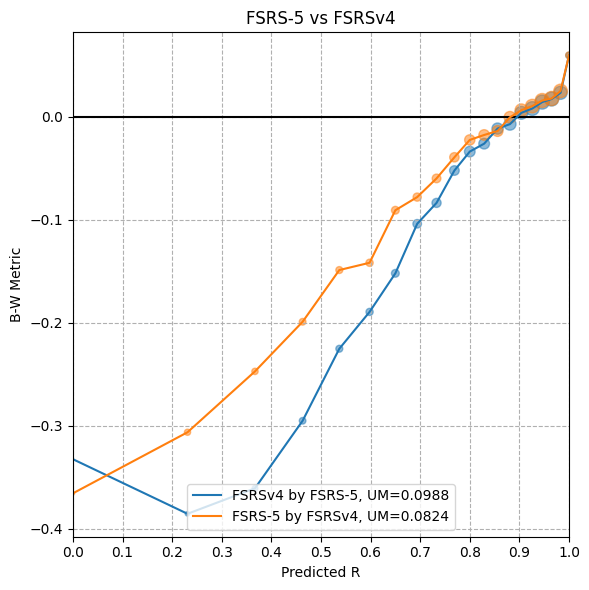

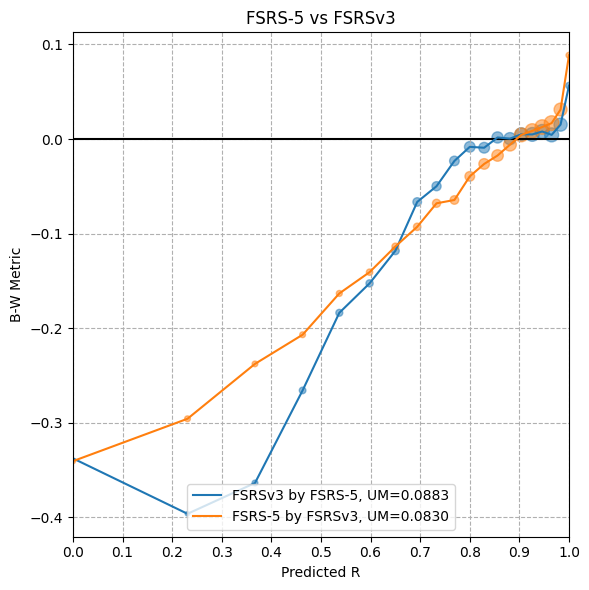

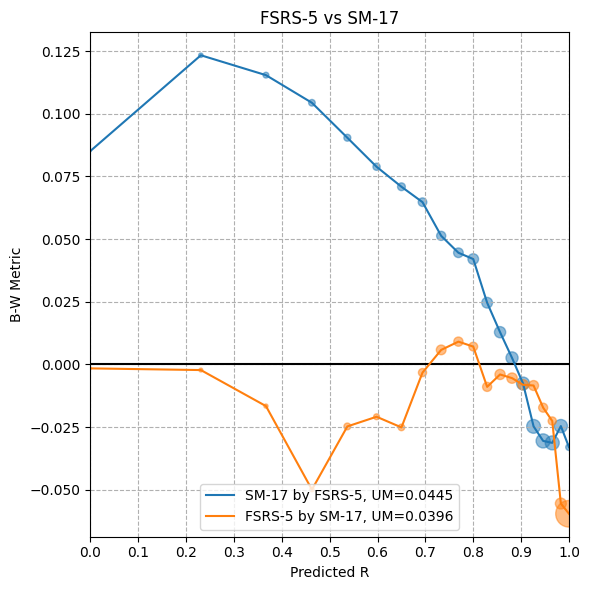

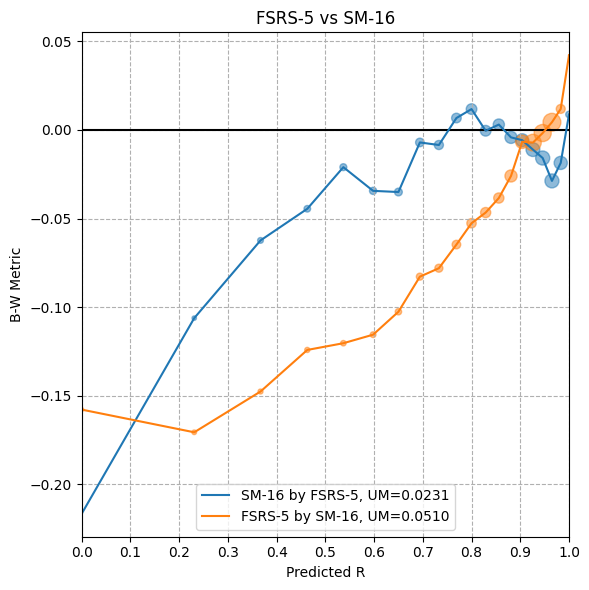

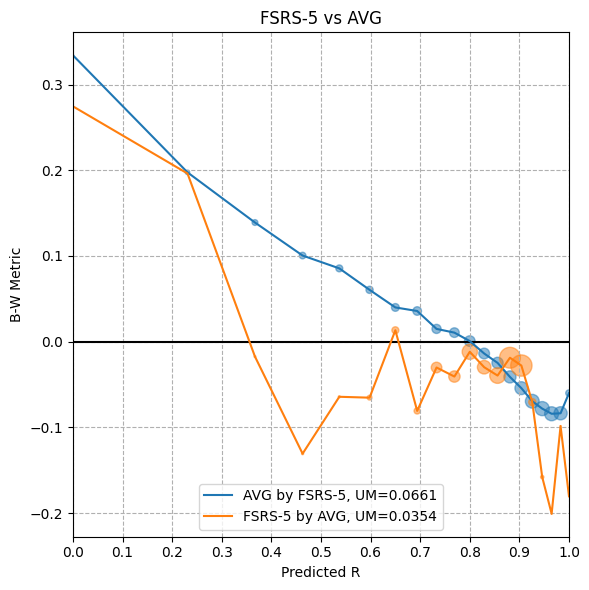

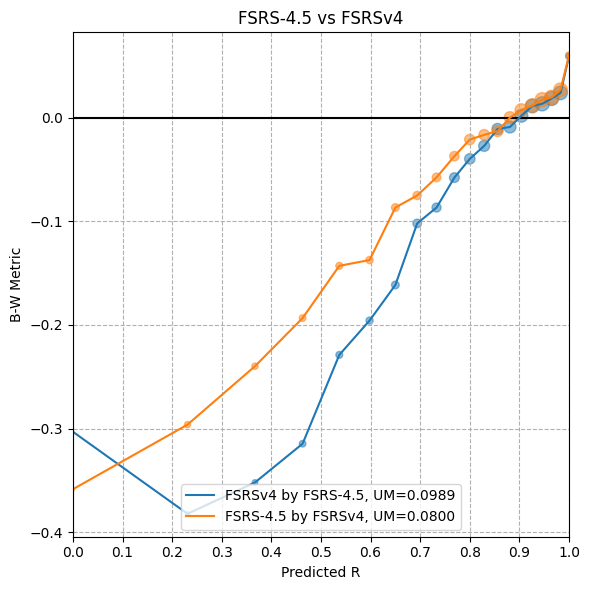

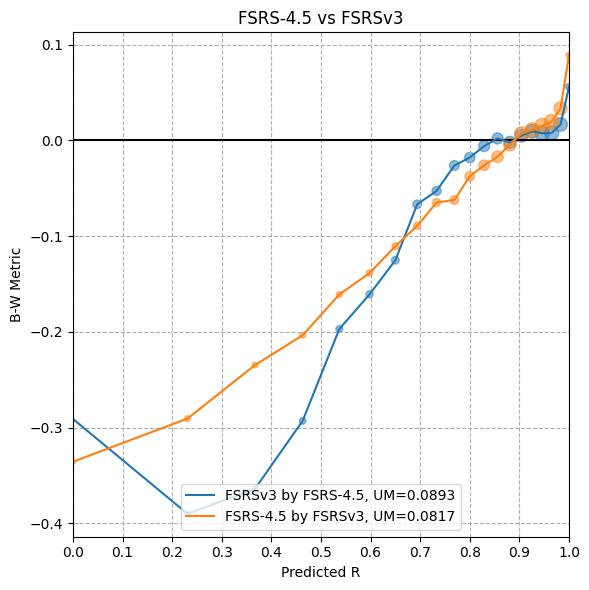

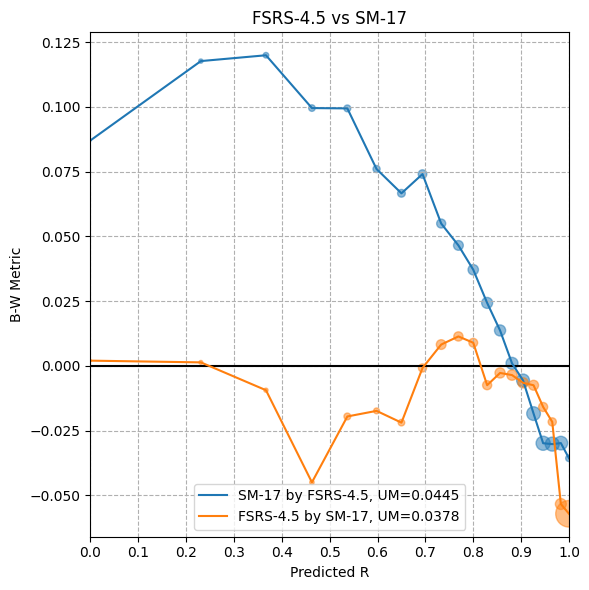

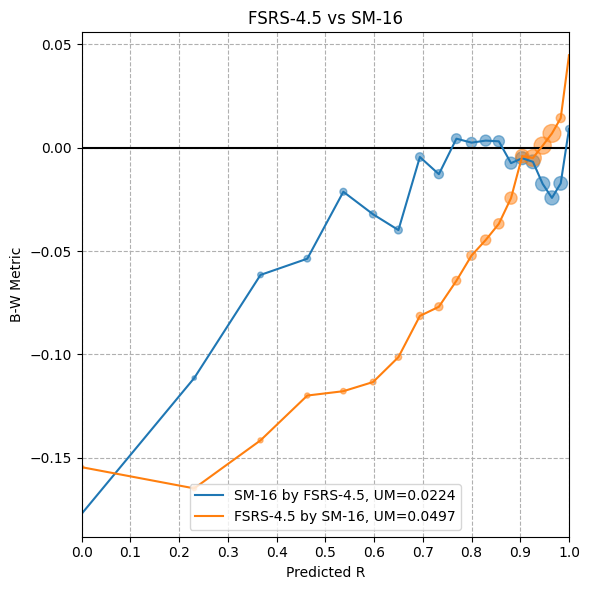

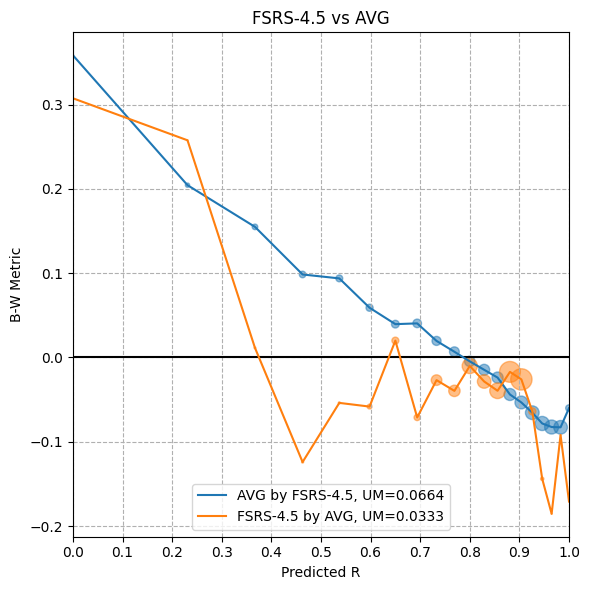

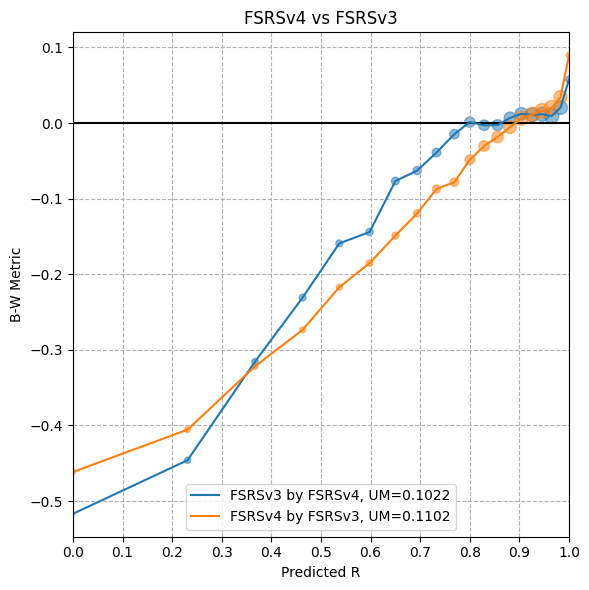

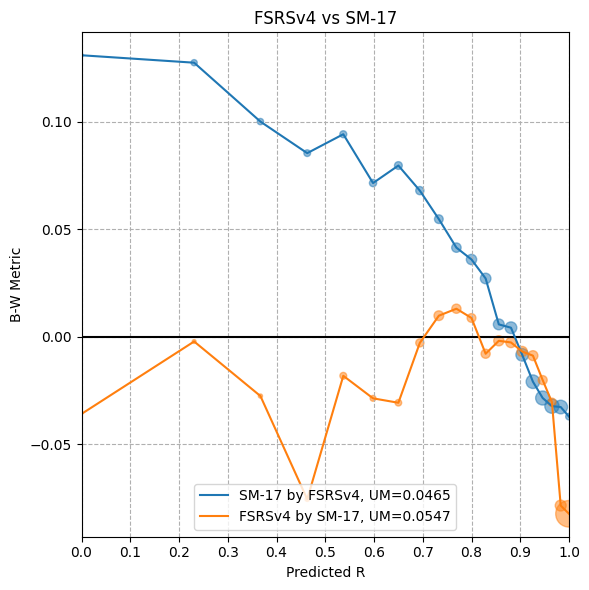

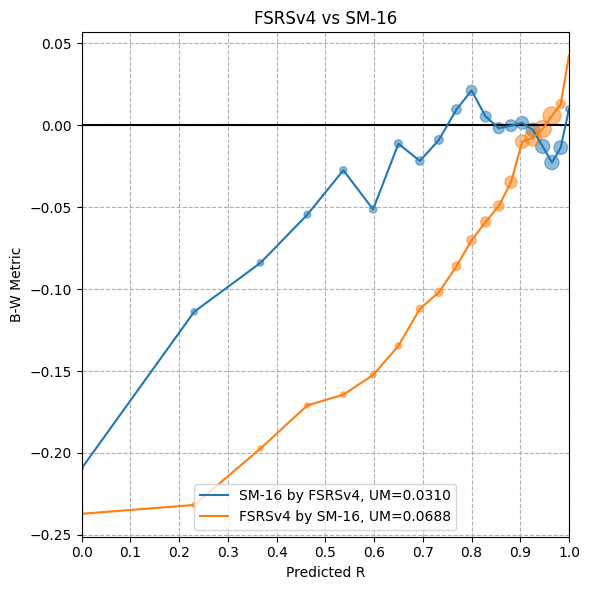

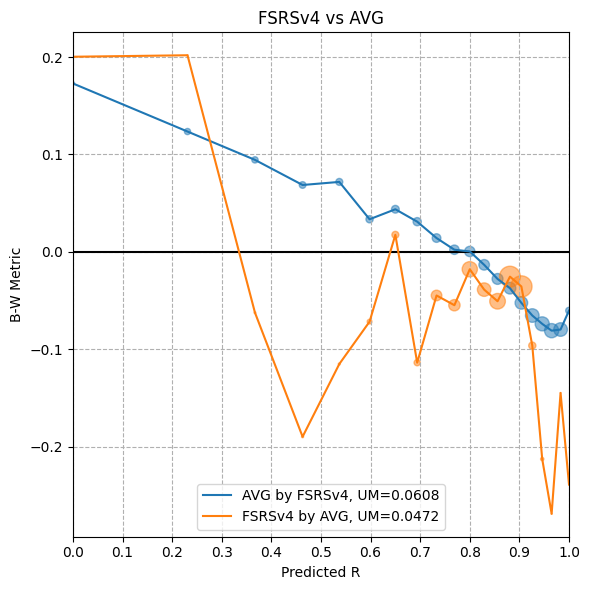

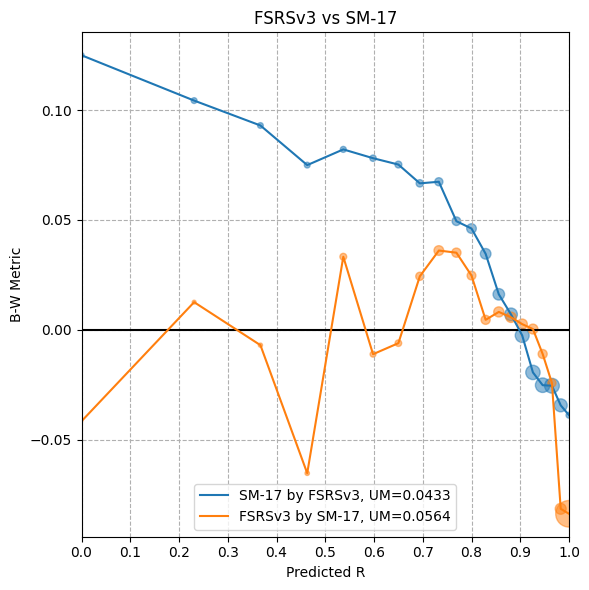

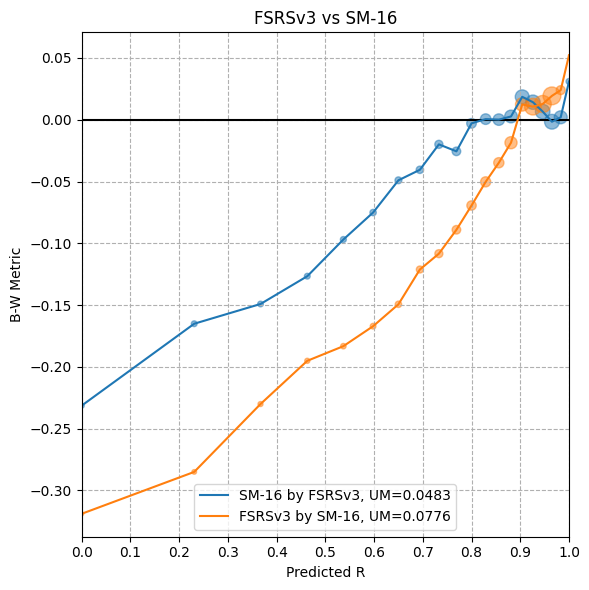

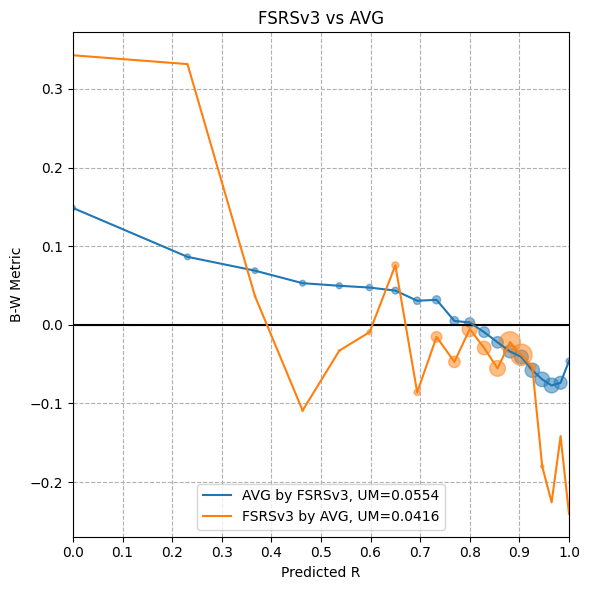

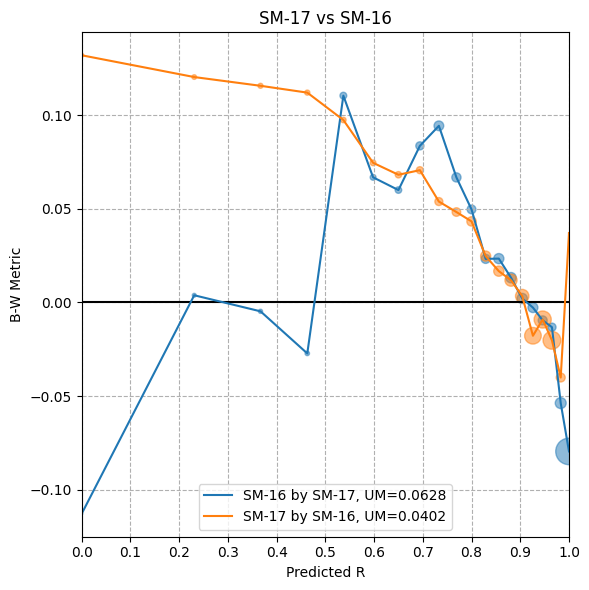

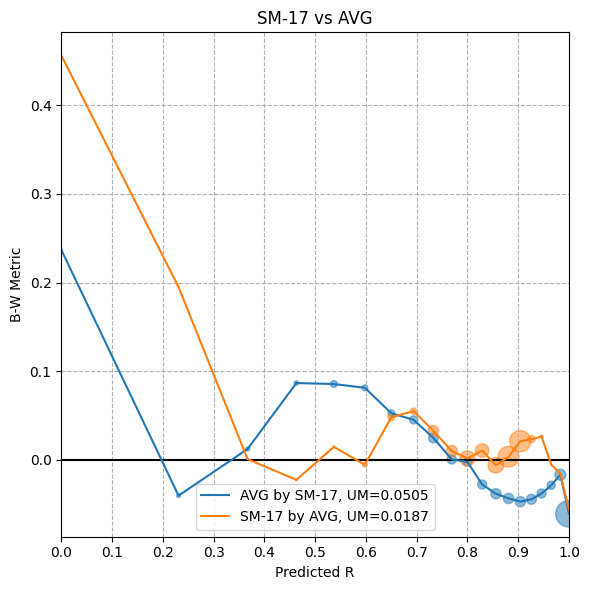

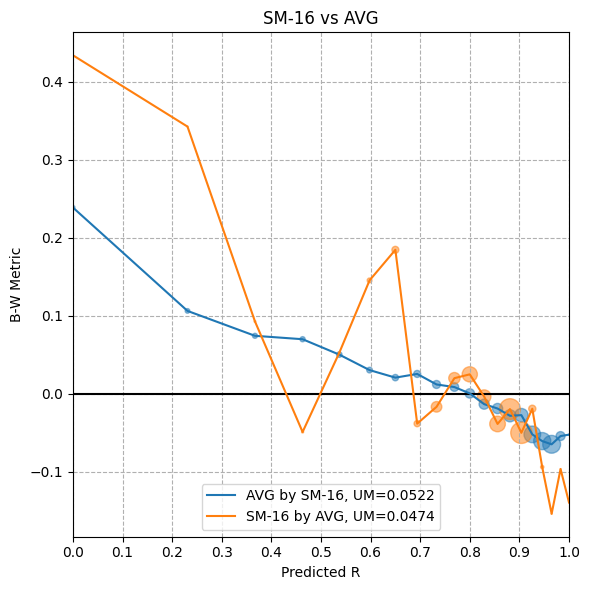

[{'FSRS-5_evaluated_by_FSRS-6': 0.0605, 'FSRS-6_evaluated_by_FSRS-5': 0.0266},
 {'FSRS-4.5_evaluated_by_FSRS-6': 0.0577,
  'FSRS-6_evaluated_by_FSRS-4.5': 0.0269},
 {'FSRSv4_evaluated_by_FSRS-6': 0.0765, 'FSRS-6_evaluated_by_FSRSv4': 0.0287},
 {'FSRSv3_evaluated_by_FSRS-6': 0.059, 'FSRS-6_evaluated_by_FSRSv3': 0.0304},
 {'SM-17_evaluated_by_FSRS-6': 0.0419, 'FSRS-6_evaluated_by_SM-17': 0.0274},
 {'SM-16_evaluated_by_FSRS-6': 0.0325, 'FSRS-6_evaluated_by_SM-16': 0.0194},
 {'AVG_evaluated_by_FSRS-6': 0.0675, 'FSRS-6_evaluated_by_AVG': 0.0238},
 {'FSRS-4.5_evaluated_by_FSRS-5': 0.0735,
  'FSRS-5_evaluated_by_FSRS-4.5': 0.0761},
 {'FSRSv4_evaluated_by_FSRS-5': 0.0988, 'FSRS-5_evaluated_by_FSRSv4': 0.0824},
 {'FSRSv3_evaluated_by_FSRS-5': 0.0883, 'FSRS-5_evaluated_by_FSRSv3': 0.083},
 {'SM-17_evaluated_by_FSRS-5': 0.0445, 'FSRS-5_evaluated_by_SM-17': 0.0396},
 {'SM-16_evaluated_by_FSRS-5': 0.0231, 'FSRS-5_evaluated_by_SM-16': 0.051},
 {'AVG_evaluated_by_FSRS-5': 0.0661, 'FSRS-5_evaluated_by

In [3]:
from utils import cross_comparison
import itertools

results = []

all_algorithms = ["FSRS-6", "FSRS-5", "FSRS-4.5", "FSRSv4", "FSRSv3", "SM-17", "SM-16", "AVG"]

for player, referee in itertools.combinations(all_algorithms, 2):
    results.append(cross_comparison(df, player, referee))
results

In [6]:
import numpy as np

final_results = {}

for player in all_algorithms:
    universal_metrics = []
    for result in results:
        for key, value in result.items():
            if key.startswith(player):
                universal_metrics.append(value)
    final_results[player] = np.array(universal_metrics).mean().round(4)

# Sort by value (ascending, lower is better)
sorted_results = sorted(final_results.items(), key=lambda x: x[1])

# Display result in markdown table format, bold the best algorithm and its metric
print("| Algorithm | Universal Metric↓ |")
print("|-----------|------------------|")
for i, (algo, metric) in enumerate(sorted_results):
    if i == 0:
        print(f"| **{algo}** | **{metric:.4f}** |")
    else:
        print(f"| {algo} | {metric:.4f} |")

| Algorithm | Universal Metric↓ |
|-----------|------------------|
| **FSRS-6** | **0.0262** |
| SM-16 | 0.0382 |
| SM-17 | 0.0399 |
| FSRS-4.5 | 0.0591 |
| AVG | 0.0598 |
| FSRS-5 | 0.0611 |
| FSRSv3 | 0.0735 |
| FSRSv4 | 0.0793 |
